# SARI Python Earth Science Application

## Introduction 

In the previous session, we looked at how to read in geographic data and explore the data using Python. In this next session, we are going to analyze geographic data for an Earth science application using Python.

During this application, we are going to focus on reading in spatial data in the form of a raster (image), manipulate the data, and perform calculations to extract land cover information. Then we are going to use a vector data set (point, line, or polygon) to summarize results from the raster data for both time periods and visualize the results.

At the end of this exercise we will have an understanding of how to perform calculations on raster data and save our results then use that extracted information to display and interactive map that people can view.



## Application

We are going to focus on an urban development application using satellite imagery to extract that land cover class. This application is going to be split into two sections: (1) processing raster data and (2) processing vector data. Built-up extent information over Chiang Mai, Thailand is going to be extracted from Landsat 5 TM imagery (raster data) from both 1990 and 2010 using the methods from [*Xu* [2007]](http://info.asprs.org/publications/pers/2007journal/december/2007_dec_1381-1391.pdf). After we calculate the built-up area over we are going to use sub-district level data (vector data) over the area of study to summarize percent area of each region and visualize the change from 1990 to 2010. 



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division, print_function

#import dependencies
import warnings
import folium
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from folium import plugins
from folium.features import *
from rasterstats import zonal_stats
from affine import Affine

warnings.simplefilter('ignore') # simple filter to ignore warning messages when processing

## 1. Processing raster datasets

### Opening and Exploring Data

Here we are going to read in the Landsat Thematic Mapper (TM) image from Apr. 3rd, 1990. This data has been preprocessed to be formatted as a seven-band image clipped to our study area shown later on in this example. As we read in the data we are going to view the dimensions of the data.


In [3]:
cm90 = rasterio.open('../data/LT05_L1TP_19900403_T1_ChiangMaiComposite.TIF') # open 1990 data for reading
print("Number of bands:",cm90.count) # get the number of bands
print("Image height", cm90.height) # get the y dimension
print("Image width", cm90.width) # get the x dimension

Number of bands: 7
Image height 3161
Image width 2754


As we can see from the print statements this dataset has 7 bands (band1=blue, band2=green, and so on) with 2754 pixels along the x-axis and 3161 pixels along the y-axis.

With the raster data model, the x- and y-axis dimensions help provide geographic context relative to a geographic transformation. This geographic transformation information is typically defined by a point at the upper left corner of the image with the geographic width and height for each pixel accompanying that point. We are going to view the geographic transformation of the Landsat data with the projection information.

In [4]:
proj = cm90.crs # save projection information to a variable
transform = cm90.transform # save the geographic transformation to a variable

# print the geographic metadata
print('Projection information:',proj)
print('Geographic transformation:',transform)

Projection information: CRS({'init': 'epsg:32647'})
Geographic transformation: [459918.3576624475, 30.0, 0.0, 2119429.5066297203, 0.0, -30.0]


The resulting geographic information can be a little cryptic if you don't know what it means...first we are going to dive deeper into the projection. There is this EPSG code; each commonly used geographic projection that is defined has an EPSG code. You can find what projection a code is by searching at this website: [www.spatialreference.org](http://spatialreference.org). From searching for the projection code, we can find that the Landsat data is in the WGS84/UTM zone 47N projection. 

Next, the geographic transformation is an affine matrix that has six values. These values define where the raster pixels are supposed to be on a geographic projection. Here are the affine values (Width of a pixel in projection units, left point on the x-axis, rotation on the x-axis, rotation on the y-axis,  height of a pixel in projection units, top point on the y-axis).



### Data format

The raster data is currently a RasterIO reader variable, this means we can only read information from the dataset and not do any processing. For us to do processing we are going to read the data in as a [NumPy array](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html). NumPy is a Python package that allows arithmetic to be applied on the array elementwise very efficiently.

In [5]:
data90 = cm90.read() # read in the raster dataset as a numpy array
cm90.close() # close the dataset to free the memory
print("Variable data type:", type(data90)) # print the data type for the data90 variable
print("Array dimensions", data90.shape) # print the dimensions of the numpy array

Variable data type: <class 'numpy.ndarray'>
Array dimensions (7, 3161, 2754)


As we see from printing the data type, the `data90` variable is a NumPy array. Furthermore, we can see that the NumPy array has the same dimensions as the original raster data: 7 bands, 3161 pixels along the y-axis, and 2754 pixels along the x-axis.

Before we start doing the processing we are going to do a few preprocessing steps. First, we are going to mask nodata values. When you read in image data as a NumPy array all values, including nodata values that a GIS software mask, have a value. Landsat TM data is 8-bit data with a value range of 0-255. Therefore, any values outside of that range are nodata.

In [6]:
data90 = np.ma.masked_where(data90>255,data90) # mask no data values
print("Variable data type:", type(data90))

Variable data type: <class 'numpy.ma.core.MaskedArray'>


Now when we view the variable type, we can see that it changed from a NumPy array to a masked NumPy array. This means that all data values that met the criteria in the above syntax will not be processed in subsequent steps. Masking data nodata values also helps with visualization where only the data you would like will be shown.

Up to this point we have been processing raster data in variables without seeing the data. It is always good to view the data so you can visualize what you have been doing. Here we are going to display the near-infrared band (band 4).

Minimum value: 26	Maximum value: 152


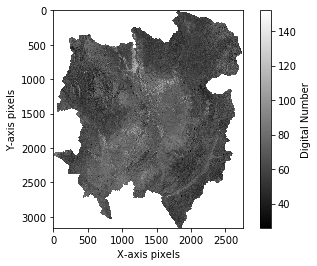

In [7]:
imshow(data90[3,:,:],cmap='gray',interpolation='nearest') # display the image
ylabel('Y-axis pixels') # label the y-axis
xlabel('X-axis pixels') # label the x-axis
cb = colorbar() # display a colorbar
cb.set_label('Digital Number') # label the colorbar

# print the dynamic data range
print("Minimum value: {0}\tMaximum value: {1}".format(data90[3,:,:].min(),data90[3,:,:].max()))

From this simple visualization, we can infer a lot of information. First, notice that the units along the x- and y-axis are in pixels. When we read in the raster as an array, we lost the geographic information associated with the image. The geographic transform and projection will be added back in later as a final step (remember we saved this data to variables earlier). Also, we can see the dynamic range of the data. The minimum value is 26 and the maximum value is 152.

### Data preprocessing

As part of the methodology outlined by *Xu* [2007], we will need to perform preprocessing step. This is a simple atmospheric correction on the Landsat image. This atmospheric correction is the Dark Object Subtract (DOS) technique given by the following equation:

\begin{aligned}
\lambda_{\mathit{cor}} = \lambda_{\mathit{i}} - min(\lambda_{\mathit{i}})
\end{aligned}

where $\lambda_{\mathit{cor}}$ is the resulting corrected image for wavelength $\mathit{i}$ and $min(\lambda)$ is the minimum value in the image for that wavelength.

More information on the DOS techniques and rationale behind the method is described by *Vincent* [1972] and *Rowan et al.* [1974].  

In [8]:
# loop over each band in image array
for i in range(data90.shape[0]):
    do = data90[i,:,:].min() # find dark object for each band
    data90[i,:,:] = data90[i,:,:] - do # apply DOS at each band

Now that we have applied the DOS, we want to see the results of the workflow. We will check our output results by visualizing the data again and checking the dynamic range.

Minimum value: 0	Maximum value: 126


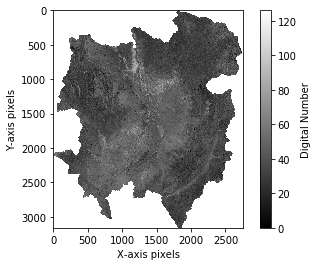

In [9]:
imshow(data90[3,:,:],cmap='gray',interpolation='nearest') # display a band in the corrected image
ylabel('Y-axis pixels') # label the y-axis
xlabel('X-axis pixels') # label the x-axis
cb = colorbar() # display a colorbar
cb.set_label('Digital Number') # label the colorbar

# print the dynamic data range
print("Minimum value: {0}\tMaximum value: {1}".format(data90[3,:,:].min(),data90[3,:,:].max()))

When viewing the data, there is little noticeable change. However, the data has all been adjusted by the DO values when we print the dynamic range. Now the minimum value is 0 and the maximum value has been adjusted by the minimum value from earlier.

The last preprocessing step we are going to perform is to extract specific bands we are using in our algorithm and convert their [data type](https://en.wikibooks.org/wiki/Python_Programming/Data_Types#Built-in_Data_types). To do calculations, specifically calculations with divisions, we want the data in a float data type and we force the data to be floating type using the built-in `.astype()` function for NumPy arrays. 

In [10]:
 # extract bands from the Landsat TM image
grn = data90[1,:,:].astype(np.float) # get the green band (2)
red = data90[2,:,:].astype(np.float) # get the red band (3)
nir = data90[3,:,:].astype(np.float) # get the NIR band (4)
swir1 = data90[4,:,:].astype(np.float) # get one of the SWIR bands (5)

### Extraction of built-up area

Now that we have performed some preprocessing on the data, we are going to perform the built-up area extraction. Per the workflow of *Xu* [2007] we first calculate three indices: (1) the normalized difference built-up index (NDBI), (2) the modified normalized difference water index (MNDWI), and (3) the soil-adjusted vegetation index.

First, we are going to calculate the NDBI and visualize the results to see how calculations are done. The equation for NDBI defined as:

\begin{aligned}
NDBI = \dfrac{SWIR-NIR}{SWIR+NIR}
\end{aligned}

where $SWIR$ is the short-wave infrared band (band 5 on the Landsat TM sensor) and $NIR$ is the near-infrared band (band 4 on the Landsat TM sensor). The values range for NDBI is -1 to 1 where values closer to one correspond with built-up areas. 

The following code will first calculate the NDBI using the above equation and then display the resulting image and the value range.

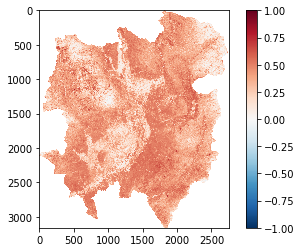

In [11]:
ndbi = (swir1-nir) / (swir1+nir) # normalized difference built-up index
imshow(ndbi,cmap='RdBu_r',interpolation='nearest')
colorbar()

In the resulting image, we can see that the value ranges are what we expect from the calculations with areas in red correspond to built-up areas.

Two more indices need to be calculated as part of the workflow. These are the MNDWI and SAVI. 

The equation for MNDWI defined as:

\begin{aligned}
MNDWI = \dfrac{GREEN-SWIR}{GREEN+SWIR}
\end{aligned}

where $GREEN$ is the green band (band 2 on the Landsat TM sensor) and $SWIR$ is the short-wave infrared band (band 5 on the Landsat TM sensor). The value range for MNDWI will be -1 to 1 where values closer to one correspond to water areas.

The SAVI is calculated using the following equation:

\begin{aligned}
SAVI = \dfrac{(NIR-RED)(1+l)}{NIR+RED+l}
\end{aligned}

where $NIR$ is the near-infrared band (band 4 on the Landsat TM sensor), $RED$ is the red band (band 3 on the Landsat TM sensor), and $l$ is a correction factor ranging from 0 for very high vegetation densities to 1 for very low vegetation densities. The value range for SAVI is -2 to 2 but largely depends on the value for $l$ used.  Greater values correspond with vegetated areas.

The following code calculates the MNDWI and SAVI using the above equations. For the SAVI calculation, a value of 0.5 is used for the coefficient $l$ to represent intermediate vegetation density for the study region.

In [12]:
l = 0.5 # veg density correction factor
mndwi = (grn-swir1) / (grn+swir1) # modified normalized difference water index
savi = ((nir-red)*(1+l)) / (nir+red+l) # soil-adjusted vegetation index

At the end of our index calculation we have three separate arrays for each index. For visualizations purposes, we are going to make a composite RGB image using the three indices. In the code, we assign the NDBI, SAVI, and MNDWI indices to the red, green, and blue visualization channels, respectively. In the resulting image, we should see built-up areas displayed as red, vegetated areas displayed as green, and water areas displayed as blue.

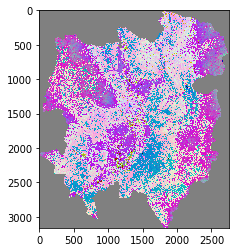

In [13]:
indices = np.dstack([ndbi,savi,mndwi]) # stack the arrays in a 3-dimensional array for visualization
imshow(((indices+1/2)*255).astype(np.uint8),interpolation='nearest') # display the image

From visual interpretation of the image, we can infer where the built-up areas are. To fully extract that information, we are going to perform another calculation. This will be a simple logic-based calculation to identify built-up areas using the idea that if NDBI values are larger than both the SAVI and MNDWI then a pixel must be a built-up area. This calculation is defined as:

\begin{aligned}
Builtup =  NDBI > SAVI \quad  and \quad NDBI > MNDWI
\end{aligned}
   
The following code implements the logic calculations to test for built-up areas. First, we perform two tests to find areas where NDBI is greater than the other indices. Then, we test for areas where both cases are true. The result is an image with values of 0 (False) and 1 (True), where a value of 1 means the pixel was classified as built-up area.

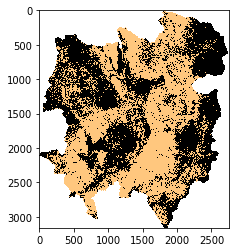

In [14]:
test1 = ndbi > savi # test that ndbi greater than savi
test2 = ndbi > mndwi # test that ndbi greater than mndwi
builtup90 = (test1&test2).astype(np.int16) # areas where both tests are true
imshow(builtup90, cmap='copper',interpolation='nearest') # display resulting image

We can compare our extracted built-up areas from the logic calculations to the RGB composite above. When comparing the two images, we see our extracted area corresponds with the red areas. This gives us confidence that our methods did what we expected by extracting areas where the NDBI values were greater than the other indices.

### Saving results

Now that we have extracted the built-up areas from the imagery, we are going to save the results of our workflow in a GeoTiff dataset. This output dataset will then be able to be used in other GIS software for visualization or other processing.

To do this we must add in our geographic information again (remember NumPy arrays are in arbitrary space!). The RasterIO package allows us to write the image to a GeoTiff file and add in metadata with the geographic information using simple commands.

In [15]:
# open geotiff file for writing and provide geographic information
builtup_out = rasterio.open('../data/ChiangMai_builtup_1990.TIF','w', 
                           driver='GTiff', height=builtup90.shape[0], width=builtup90.shape[1],
                           count=1, dtype=np.int16, crs=proj, transform=transform, nodata=0)

builtup_out.write(builtup90,1) # write the data to the first band
builtup_out.close() # flush

### Processing the 2010 Data

Now that we have gone through and extracted the built-up area from the 1990 imagery, we will need to perform the methodology on the 2010 imagery. Since we now know how this is done, we are going to execute all of the code needed for the algorithm at once for the 2010 case. Again, this code reads in the raster data, performs the preprocessing steps (mask nodata and DOS), calculates the needed indices, extracts built-up area, and finally saves the results to a file.

In [16]:
cm10 = rasterio.open('../data/LT05_L1TP_20100325_T1_ChiangMaiComposite.TIF') # open 2010 data for reading

data10 = cm10.read() # read in the raster dataset as a numpy array
cm10.close() # close the dataset to free the memory

data10 = np.ma.masked_where(data90>255,data10) # mask nodata values

# loop over each band in image array for DOS
for i in range(data10.shape[0]):
    do = data10[i,:,:].min() # find dark object for each band
    data10[i,:,:] = data10[i,:,:] - do # apply DOS at each band
    
# extract bands from the Landsat TM image
grn = data10[1,:,:].astype(np.float) # get the green band (2)
red = data10[2,:,:].astype(np.float) # get the red band (3)
nir = data10[3,:,:].astype(np.float) # get the NIR band (4)
swir1 = data10[4,:,:].astype(np.float) # get one of the SWIR bands (5)

# calculate indices
l = 0.5 # veg density correction factor
ndbi = (swir1-nir) / (swir1+nir) # normalized difference built-up index
mndwi = (grn-swir1) / (grn+swir1) # modified normalized difference water index
savi = ((nir-red)*(1+l)) / (nir+red+l) # soil-adjusted vegetation index

# extract built-up areas
test1 = ndbi > savi # test that ndbi greater than savi
test2 = ndbi > mndwi # test that ndbi greater than mndwi
builtup10 = (test1&test2).astype(np.int16) # areas where both tests are true

# save out results
# open geotiff file for writing and provide geographic information
builtup_out = rasterio.open('../data/ChiangMai_builtup_2010.TIF','w', 
                           driver='GTiff', height=builtup10.shape[0], width=builtup10.shape[1],
                           count=1, dtype=np.int16, crs=proj, transform=transform, nodata=0)

builtup_out.write(builtup10,1) # write the data to the first band
builtup_out.close() # flush

We should now have two new GeoTiff files in our folders named "ChiangMai_builtup_YYYY.TIF", where YYYY is the year that the data is associated with. These GeoTiff files can now be used in GIS software such as QGIS or ArcGIS for further analysis and visualizations.

The raster data is now all processed. We are now going to use vector data to analyze the changes in built-up area from 1990 to 2010.

## 2. Processing vector datasets

### Opening and Exploring Data

As with most processing, we start with reading in the dataset. We will use the GeoPandas package again to do our vector processing. The following code opens up sub-district data over the Chiang Mai region (which overlaps geographically with the Landsat imagery used in the previous section). When we read in the dataset, we are going to print the first ten rows of the dataset so we can see what the data comprises of.

In [17]:
chiangmai = gpd.read_file('../data/chiangmai_subdistrict.shp') # open the vector dataset
chiangmai.head(10) # print the first 10 features

,OBJECTID,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ID_2,NAME_2,TYPE_2,...,TYPE_3,ID_4,NAME_4,TYPE_4,Name,Type,Shape_Leng,Shape_Area,shparea,geometry
0,189815,226,THA,Thailand,19,Lamphun,Changwat,289,Pa Sang,Amphoe,...,Tambon,0,None,None,None,0,0.137600,0.000698,9.11752,"POLYGON ((98.90352630615234 18.52404022216797,..."
1,189821,226,THA,Thailand,9,Chiang Mai,Changwat,142,K. Mae On,King Amphoe,...,Tambon,0,None,None,None,0,0.497495,0.009596,125.60800,"POLYGON ((99.36299896240234 18.85029029846191,..."
2,189822,226,THA,Thailand,9,Chiang Mai,Changwat,136,Doi Saket,Amphoe,...,Tambon,0,None,None,None,0,0.127183,0.000924,12.10430,"POLYGON ((99.09825134277338 18.85268020629888,..."
3,189860,226,THA,Thailand,9,Chiang Mai,Changwat,153,San Pa Tong,Amphoe,...,Tambon,0,None,None,None,0,0.170372,0.001641,21.45330,"POLYGON ((98.86634826660156 18.64039993286138,..."
4,189862,226,THA,Thailand,19,Lamphun,Changwat,288,Muang Lamphun,Amphoe,...,Tambon,0,None,None,None,0,0.253210,0.001917,25.07220,"POLYGON ((99.00985717773443 18.64079284667969,..."
5,189863,226,THA,Thailand,19,Lamphun,Changwat,288,Muang Lamphun,Amphoe,...,Tambon,0,None,None,None,0,0.493266,0.010380,135.70900,"POLYGON ((99.04588317871099 18.61183929443365,..."
6,189864,226,THA,Thailand,9,Chiang Mai,Changwat,153,San Pa Tong,Amphoe,...,Tambon,0,None,None,None,0,0.187137,0.001456,19.03200,"POLYGON ((98.90026092529291 18.63484954833984,..."
7,189876,226,THA,Thailand,19,Lamphun,Changwat,288,Muang Lamphun,Amphoe,...,Tambon,0,None,None,None,0,0.141507,0.001085,14.17470,"POLYGON ((98.97177124023449 18.49759292602533,..."
8,189877,226,THA,Thailand,19,Lamphun,Changwat,289,Pa Sang,Amphoe,...,Tambon,0,None,None,None,0,0.126112,0.000751,9.81859,"POLYGON ((98.91346740722656 18.51905059814447,..."
9,189883,226,THA,Thailand,9,Chiang Mai,Changwat,148,Muang Chiang Mai,Amphoe,...,Tambon,0,None,None,None,0,0.649682,0.006748,88.32560,"POLYGON ((98.9881973266601 18.84762954711914, ..."


As we see from the printed results, this data has 22 columns of data including information on the district level name, type of district, and geographic shape/area for each feature in the dataset. Now we want to see how many features (rows) this dataset has.

In [18]:
print("Total number of features:",chiangmai.index.size) # print total number or features

Total number of features: 105


From this we can see that there are a total of 105 features in the vector dataset. It is always good to see what kind of data you have and how the data is formatted. Now, let's visualize the data so we can see the geographic area that we are working with.

Text(88.802,0.5,'Latitude')

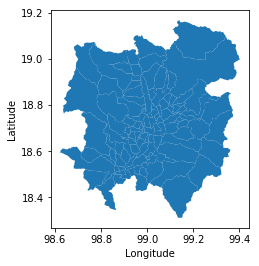

In [19]:
chiangmai.plot() # plot the vector data
plt.xlabel("Longitude") # label x axis
plt.ylabel("Latitude") # label y axis

We can see that the vector dataset has the same shape as the raster dataset, so they should align...However, notice the units on the x- and y-axis. These units are in decimal degrees, meaning the projection is a Geographic Coordinate System.

### Handling Geographic Projections

Remember that the raster dataset projection was in a UTM Zone 47N projection with units in meters. The raster projection does not align with the vector projection. If you are familiar with GIS processing software, such as ArcGIS or QGIS, you know that the software handles "projecting on the fly" for processing, this does not happen when using Python for geoprocessing. You will have to be careful to make sure all data is in the same geographic projection before performing any calculations.

We now have to make sure that the geographic projections align between the raster and vector dataset so we can do calculations. Python uses the EPSG codes for projection information (as seen from the raster example above) so first, we are going to print the EPSG code to make sure we get the correct projection information.

In [20]:
print('Vector projection:',chiangmai.crs) # check projection

Vector projection: {'init': 'epsg:4326'}


If you were to search for this EPSG code, you can see that the projection is the WGS84 coordinate system. This is a very common coordinate system for global datasets. Again, this projection does not match the raster dataset's project. We are going to need to do some reprojecting, and the following code will do this for us.

In [21]:
# define projection EPSG codes...
utm47n_proj = {'init': 'epsg:32647'} # ...for UTM Zone 47N
wgs84_proj = {'init' :'epsg:4326'} # ...for WGS84

chiangmai = chiangmai.to_crs(utm47n_proj) # perform a reprojection
print("New projection:",chiangmai.crs) # check projection

New projection: {'init': 'epsg:32647'}


We can see from printing the new projection information that the EPSG code matches the raster dataset's. We are going to display the vector data to see if any changes were made to the dataset while reprojecting.

Text(71.7797,0.5,'Northing [m]')

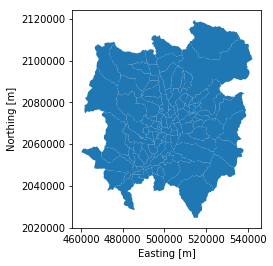

In [22]:
chiangmai.plot() # plot the vector data
plt.xlabel("Easting [m]")
plt.ylabel("Northing [m]")

As shown, the reprojection did not change the vector features, however, notice the change in projection units. The original units were in decimal degrees (latitude and longitude) and now the units are in meters. Now we are confident that the projections between the raster and vector data match, we can perform the geoprocessing.

### Zonal Statistics and Field Calculations

We are going to use zonal statistics to summarize the raster information on a feature basis within the vector dataset. In Python there is a powerful package to perform zonal statistical calculations with raster and vector dataset; this is the [rasterstats package](http://pythonhosted.org/rasterstats/). We will use the `zonal_stats()` function, the inputs are the vector dataset, the raster dataset in NumPy array format, and the affine transformation for the raster data. The following code performs the zonal statistics geoprocessing for the 1990 built-up raster dataset and shows the results for the first ten features.

In [23]:
stats90 = zonal_stats(chiangmai, builtup90,affine=Affine.from_gdal(*transform)) # do the zonal statistics
stats90[:10] # display the results from the first ten features

[{'count': 9058, 'max': 1.0, 'mean': 0.3108854051667035, 'min': 0.0},
 {'count': 124316, 'max': 1.0, 'mean': 0.25592844042601115, 'min': 0.0},
 {'count': 11978, 'max': 1.0, 'mean': 0.9285356486892636, 'min': 0.0},
 {'count': 21272, 'max': 1.0, 'mean': 0.49482888303873634, 'min': 0.0},
 {'count': 24869, 'max': 1.0, 'mean': 0.4672885922232498, 'min': 0.0},
 {'count': 134629, 'max': 1.0, 'mean': 0.8275408715804173, 'min': 0.0},
 {'count': 18888, 'max': 1.0, 'mean': 0.11112875900042354, 'min': 0.0},
 {'count': 14076, 'max': 1.0, 'mean': 0.973643080420574, 'min': 0.0},
 {'count': 9748, 'max': 1.0, 'mean': 0.7415880180549856, 'min': 0.0},
 {'count': 87418, 'max': 1.0, 'mean': 0.4799583609782882, 'min': 0.0}]

The default results from the process are the number of pixels in a feature (count), the maximum pixel value in a feature (max), the average pixel value in a feature (mean), and minimum pixel value in a feature (min). The output statistics for each feature can be modified, more information to change the output statistics can be found at the rasterstats documentation. 

If you notice, the resulting zonal statistics are in a different format from the actual vector data. The output is a [list](https://www.tutorialspoint.com/python/python_lists.htm) of [dictionaries](https://www.tutorialspoint.com/python/python_dictionary.htm) but the vector data is in a DataFrame format. We are going to need to convert the zonal statistics data to a DataFrame and perform a table join to add the resulting zonal statistics data to the vector data. The following code performs the data conversion and join while saving the output to a new variable.

In [24]:
join_vector = chiangmai.join(pd.DataFrame(stats90)) # join tables

We now have a `join_vector` variable that holds the original geographic and attribute data from earlier and now has the computed zonal statistics data. We are now going to use the data fields (columns) from `join_vector` to calculate new fields in the original vector dataset. We do this by calling the field name in each dataset, if we assign a field name it will be created automatically.

In [25]:
chiangmai['bu_pct90'] = join_vector['mean'] # add new field for percent area that is built-up
chiangmai['bu_area90'] = (chiangmai['bu_pct90'] * chiangmai.area) / 10e6  # convert built-up percent to area in sq km
print(chiangmai['bu_area90'][:10]) # print the first ten features built-up area

0     0.253324
1     2.863736
2     1.000678
3     0.947568
4     1.045852
5    10.026793
6     0.188803
7     1.233386
8     0.650716
9     3.775998
Name: bu_area90, dtype: float64


You may be wondering, "Why did we not just join the zonal statistics outputs to the `chiangmai` variable?" We did not do this because we need to calculate the same statistics/fields using the 2010 built-up raster dataset for comparison. Vector datasets only allow one unique field name, such as 'count', in a table. To get around this, we saved the joined tables to a new variable and passed that same information to our original variable as above.

Before we calculate the 2010 built-up zonal statistics, we have to clear the `join_vector` variable. We do this using the below code. 

In [26]:
join_vector = None # assign the variable to be nothing

Now we are ready to calculate the statistics and fields using the 2010 built-up raster. We do this with the same workflow above: calculate the zonal statistics, join the tables, calculate new fields in the original dataset. 

In [27]:
stats10 = zonal_stats(chiangmai, builtup10,affine=Affine.from_gdal(*transform)) # do the zonal statistics
join_vector = chiangmai.join(pd.DataFrame(stats10)) # join the tables
chiangmai['bu_pct10'] = join_vector['mean']
chiangmai['bu_area10'] = (chiangmai['bu_pct10'] * chiangmai.area) / 10e6                          

join_vector = None # assign the variable to be nothing

We now have built-up area and percent area data for each feature from the 1990 and 2010 time periods in our original dataset. For our application, we want to show the difference from 1990 to 2010. We do this, again, by using a simple subtraction between the two time periods resulting in new difference fields show using the syntax below.

In [28]:
chiangmai['bu_areadiff'] = chiangmai['bu_area10'] - chiangmai['bu_area90'] # difference in built-up area
chiangmai['bu_pctdiff'] = chiangmai['bu_pct10'] - chiangmai['bu_pct90'] # difference in built-up percent area

We finally have all of the calculated data for our application. The results from the above code have data showing increases or decreases in built-up area/percent area from 1990 to 2010.

### Saving Vectors and Making Web Maps

After we have all performed all of the processing, we want to save the file. We do this using the below syntax. Before we save the file, we are going to reproject the data back to its original projection, WGS84. We use the same syntax as the previous reprojection but give it the WGS84 EPSG code. Then we finally save the file.

In [29]:
# reproject the joined vector data to a WGS84 projection
out_vector = chiangmai.to_crs(wgs84_proj)

# save the data to a geojson
out_vector.to_file('../data/chiangmai_builtup.shp')

We now have a new shapefile in our folders called "chiangmai_builtup.shp" that we can use with other GIS software for further analysis or visualization.

Our last step for this application is to convert the processed data into a web map so we can show our users the application. Python provides an easy to use interactive map creation package, [Folium](https://folium.readthedocs.io/en/latest/). This package allows you to create interactive maps in your Python environment and save the maps as a webpage for displaying.

We are going to create the map using the below syntax. For this web map, the difference in percent area from 1990 to 2010 is going to be displayed.

In [30]:
map_ = folium.Map(location=[18.75, 99], zoom_start=9,tiles='cartodbpositron') # initialize basemap and start position

# create chorpleth map and define visualization parameters
map_.choropleth(out_vector.to_json(), data = out_vector,
                columns = ['OBJECTID', 'bu_pctdiff'], key_on = 'feature.properties.{}'.format("OBJECTID"),
                fill_color = 'RdGy', fill_opacity = 0.8, line_opacity = 0.9,
                legend_name='Pecent Built-up Difference',highlight=True)

map_.add_children(folium.map.LayerControl()) # add layer control functions

map_ # add map inline

As we can see, we now can zoom, pan, click, and view the results on a nice interactive map. However, we want a map that we can display as its own webpage, we do this by saving the map to a HTML file. We do this with the following syntax.

In [31]:
map_.save('chiangmai_builtup.html') # save the map to html page

There is now a 'chiangmai_builtup.html' file in our folder. If we open this file, we are shown a webpage with the interactive map. This is helpful as you can use Python to create you web maps and use the webpages on your own webserver.

## Conclusion

In conclusion, we performed an Earth science application using Python. This application focused on using remotely sensed datasets (Landsat TM) to extract areas that are built-up from two time periods, 1990 and 2010. We then used a vector dataset to summarize the built-up area from the two time periods over sub-district areas. Lastly, we created an interactive web map of the vector dataset showing the increase or decrease in built-up area from the two time periods.

This application highlighted the utility of Python to perform geoprocessing workflows and create information that end-users can then access for policy formation. What kind of science applications will you perform with Python?

## References

Rowan, L. C. et al. (1974), Discrimination of rock types and detection of hydrothermally altered areas in south-central Nevada by the use of computer-enhanced ERTS images, U.S. Geological  Survey  Professional Paper 883. [Link](https://pubs.usgs.gov/pp/0883/report.pdf)

Vincent, R. K. (1973), Spectral ratio imaging methods for geological remote sensing from aircraft and satellites, In *Proceedings of the American Society of Photogrammetry, Management and Utilization of Remote Sensing Data Conference*, Sioux Falls,  SD, pp. 377-397. [Link](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19730001633.pdf)

Xu, H. (2007), Extraction of Urban Built-up Land Features from Landsat Imagery Using a Thematic oriented Index Combination Technique, *Photogramm. Eng. Rem. S., 73*(12), 1381–1391. [Link](http://info.asprs.org/publications/pers/2007journal/december/2007_dec_1381-1391.pdf)